# 并行化
在Python中编写自定义算法时，可能会由于运行多层嵌套的for循环而导致代码变慢。如果内部循环之间互不依赖，代码可以并行化并提速。注意，我们是在中央处理器（CPU）上并行化代码，不要与使用图形处理单元（GPU）的GPU加速混淆。

另请参阅
* [Scikit-image并行化教程](https://scikit-image.org/docs/stable/user_guide/tutorial_parallelization.html)

In [1]:
import time
import numpy as np
from functools import partial
import timeit
import matplotlib.pyplot as plt
import platform

我们从一个在给定像素坐标处对图像进行操作的算法开始

In [2]:
def slow_thing(image, x, y):
    # Silly algorithm for wasting compute time
    sum = 0
    for i in range(1000):
        for j in range(100):
            sum = sum + x
        sum = sum + y
    image[x, y] = sum

image = np.zeros((10, 10))

现在我们使用[timeit](https://docs.python.org/3/library/timeit.html)来测量处理单个像素所需的时间。

In [3]:
%timeit slow_thing(image, 4, 5)

3.3 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


现在我们定义整个图像上的操作，并测量这个函数的执行时间。

In [4]:
def process_image(image):
    for x in range(image.shape[1]):
        for y in range(image.shape[1]):
            slow_thing(image, x, y)

In [5]:
%timeit process_image(image)

353 ms ± 42.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


这个函数相当慢，并行化可能会有意义。

## 使用joblib.Parallel进行并行化
一个简单直接的并行化方法是使用[`joblib.Parallel`](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html)和`joblib.delayed`。

In [6]:
from joblib import Parallel, delayed, cpu_count

注意下面代码块中for循环的反向写法。术语`delayed(slow_thing)(image, x, y)`在技术上是一个函数调用，但并未执行。只有当实际需要这个调用的返回值时，才会进行实际执行。详情请参见[dask delayed](https://docs.dask.org/en/stable/delayed.html)。

In [7]:
def process_image_parallel(image):
    Parallel(n_jobs=-1)(delayed(slow_thing)(image, x, y) 
                        for y in range(image.shape[0]) 
                        for x in range(image.shape[1]))

In [8]:
%timeit process_image_parallel(image)

62.4 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


7倍的加速效果还不错。`n_jobs=-1`意味着使用了所有的计算单元/线程。我们也可以打印出使用了多少个计算核心：

In [9]:
cpu_count()

16

为了文档记录的目的，我们还可以打印出执行该算法的CPU类型。这个字符串的信息量可能会因执行此笔记本的操作系统/计算机而有所不同。

In [10]:
platform.processor()

'AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD'

## 执行时间基准测试
在图像处理中，算法的执行时间通常会因图像大小而呈现不同的模式。现在我们将对上述算法进行基准测试，看看它在不同大小的图像上的表现如何。
为了将待测试的函数与给定图像绑定而不执行它，我们使用了[partial](https://docs.python.org/3/library/functools.html#functools.partial)模式。

In [11]:
def benchmark(target_function):
    """
    在几种图像大小上测试函数，并返回处理所需的时间。
    """
    sizes = np.arange(1, 5) * 10

    benchmark_data = []

    for size in sizes:
        print("Size", size)

        # make new data
        image = np.zeros((size, size))
        
        # bind target function to given image
        partial_function = partial(target_function, image)

        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=10)
        print("time", time_in_s, "s")

        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)

In [12]:
print("Benchmarking normal")
benchmark_data_normal = benchmark(process_image)
print("Benchmarking parallel")
benchmark_data_parallel = benchmark(process_image_parallel)

Benchmarking normal
Size 10
time 3.5427859 s
Size 20
time 13.8465019 s
Size 30
time 30.883478699999998 s
Size 40
time 55.4255712 s
Benchmarking parallel
Size 10
time 0.7873560999999967 s
Size 20
time 2.0985788000000127 s
Size 30
time 4.9782009000000045 s
Size 40
time 7.9171936000000045 s


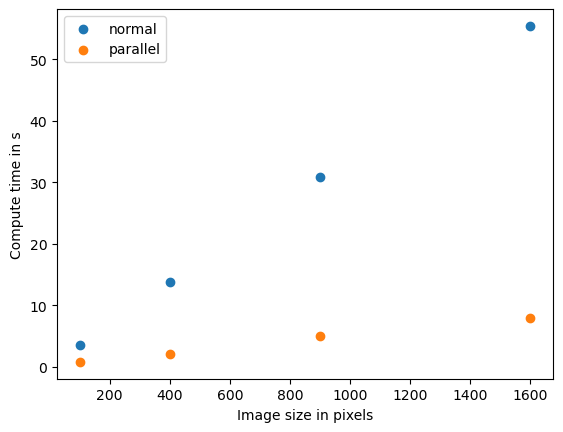

In [13]:
plt.scatter(benchmark_data_normal[:,0] ** 2, benchmark_data_normal[:,1])
plt.scatter(benchmark_data_parallel[:,0] ** 2, benchmark_data_parallel[:,1])
plt.legend(["normal", "parallel"])
plt.xlabel("图像大小（像素）")
plt.ylabel("计算时间（秒）")
plt.show()

如果我们看到这种模式，我们称之为数据大小和计算时间之间的_线性_关系。计算机科学家使用[O记号](https://en.wikipedia.org/wiki/Big_O_notation)来描述算法的[复杂度](https://en.wikipedia.org/wiki/Computational_complexity)。这个算法的复杂度是`O(n)`，其中`n`在这个例子中代表像素数量。

## 质量保证
请注意，在本节中我们只测量了算法的计算时间。我们没有确定不同优化版本的算法是否产生相同的结果。质量保证是良好的科学实践。这在GPU加速的背景下也同样重要，例如在[这里](https://arxiv.org/pdf/2008.11799)有详细描述。